##Initializations

In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
import os
os.chdir('/content/drive/MyDrive/MLPROJ')
!ls

bowl		 dataset-10.pkl    MLProject3.ipynb  Robotiq2F85.py
bowl.zip	 dataset-1.pkl	   MLProject4.ipynb  robotiq_2f_85.zip
checkpoint	 dataset_samples   PickPlaceEnv.py   __temp__.mp4
chess_set	 image_path_v2	   __pycache__	     ur5e
dataset-100.pkl  llm_cache.pickle  robotiq_2f_85     ur5e.zip


In [3]:
from IPython.display import clear_output as clc

In [4]:
!pip install ftfy regex tqdm fvcore
!pip install git+https://github.com/openai/CLIP.git
!pip install -U --no-cache-dir gdown --pre
!pip install pybullet moviepy
!pip install openai
!pip install easydict
!pip install imageio-ffmpeg
!pip install tiktoken
!pip install python-chess
!pip install -q ultralytics
!pip install -q opencv-python-headless
clc()

In [5]:
import collections
import datetime
import random
import threading
import time

import cv2  # Used by ViLD.
import clip
from easydict import EasyDict
import flax
from flax import linen as nn
from flax.training import checkpoints
from flax.metrics import tensorboard
import imageio
from heapq import nlargest
import IPython
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
from moviepy.editor import ImageSequenceClip
import numpy as np
import openai
import optax
import pickle
from PIL import Image
import pybullet
import pybullet_data
import tensorflow.compat.v1 as tf
import torch
from tqdm import tqdm
from ultralytics import YOLO
from IPython.display import clear_output as clc
import os
import re # For parsing commands
import random  # For mock LLM responses


clc()

In [6]:
if not os.path.exists('ur5e/ur5e.urdf'):
  !gdown --id 1Cc_fDSBL6QiDvNT4dpfAEbhbALSVoWcc
  !gdown --id 1yOMEm-Zp_DL3nItG9RozPeJAmeOldekX
  !gdown --id 1GsqNLhEl9dd4Mc3BM0dX3MibOI1FVWNM
  !unzip ur5e.zip
  !unzip robotiq_2f_85.zip
  !unzip bowl.zip

## Available Pick and Place

In [7]:
PICK_TARGETS = {
    # White pieces
    "white King": "e1",
    "white Queen": "d1",
    "white Rook 1": "a1",
    "white Rook 2": "h1",
    "white Knight 1": "b1",
    "white Knight 2": "g1",
    "white Bishop 1": "c1",
    "white Bishop 2": "f1",
    "white Pawn 1": "a2",
    "white Pawn 2": "b2",
    "white Pawn 3": "c2",
    "white Pawn 4": "d2",
    "white Pawn 5": "e2",
    "white Pawn 6": "f2",
    "white Pawn 7": "g2",
    "white Pawn 8": "h2",

    # Black pieces
    "black King": "e8",
    "black Queen": "d8",
    "black Rook 1": "a8",
    "black Rook 2": "h8",
    "black Knight 1": "b8",
    "black Knight 2": "g8",
    "black Bishop 1": "c8",
    "black Bishop 2": "f8",
    "black Pawn 1": "a7",
    "black Pawn 2": "b7",
    "black Pawn 3": "c7",
    "black Pawn 4": "d7",
    "black Pawn 5": "e7",
    "black Pawn 6": "f7",
    "black Pawn 7": "g7",
    "black Pawn 8": "h7",
    }




COLORS = {
    "blue":   (78/255,  121/255, 167/255, 255/255),
    "red":    (255/255,  87/255,  89/255, 255/255),
    "green":  (89/255,  169/255,  79/255, 255/255),
    "yellow": (237/255, 201/255,  72/255, 255/255),
    "orange": (242/255, 142/255,  43/255, 255/255),
    "white": (255/255, 255/255, 255/255, 255/255),
    "black": (40/255, 26/255, 13/255, 255/255)
}

square_size = 0.085
target_z = 0.02
board_size=8
z_height=0.01

start_x = -0.35 + 0.05 + (square_size / 2)
start_y = -0.08 - 0.05 - (square_size / 2)

PLACE_TARGETS = {}

# Board squares
for row in range(8):  # rows 0 to 7 represent ranks 1 to 8
    for col in range(8):  # columns 0 to 7 represent files a to h
        square_name = chr(ord('h') - col) + str(row + 1)
        PLACE_TARGETS[square_name] = [
            start_x + col * square_size,
            start_y - row * square_size,
            target_z
        ]

# Captured piece placement zones
captured_offset_x = start_x + 8 * square_size + square_size  # Right of board
captured_offset_y_white = start_y
captured_offset_y_black = start_y - 5 * square_size  # Below white captures

for i in range(1):  # Max 16 captured pieces per color
    PLACE_TARGETS[f'captured white {i+1}'] = [
        captured_offset_x,
        captured_offset_y_white - i * 0.5 * square_size,
        target_z
    ]
    PLACE_TARGETS[f'captured black {i+1}'] = [
        captured_offset_x,
        captured_offset_y_black - i * 0.5 * square_size,
        target_z
    ]



PIXEL_SIZE = 0.00267857
BOUNDS = np.float32([[start_x, start_x+8*square_size], [start_y-8*square_size, start_y], [0, 0.12]])  # X Y Z


In [8]:
PLACE_TARGETS

{'h1': [-0.2575, -0.17250000000000001, 0.02],
 'g1': [-0.1725, -0.17250000000000001, 0.02],
 'f1': [-0.0875, -0.17250000000000001, 0.02],
 'e1': [-0.0025000000000000022, -0.17250000000000001, 0.02],
 'd1': [0.08250000000000002, -0.17250000000000001, 0.02],
 'c1': [0.16750000000000004, -0.17250000000000001, 0.02],
 'b1': [0.2525, -0.17250000000000001, 0.02],
 'a1': [0.3375000000000001, -0.17250000000000001, 0.02],
 'h2': [-0.2575, -0.2575, 0.02],
 'g2': [-0.1725, -0.2575, 0.02],
 'f2': [-0.0875, -0.2575, 0.02],
 'e2': [-0.0025000000000000022, -0.2575, 0.02],
 'd2': [0.08250000000000002, -0.2575, 0.02],
 'c2': [0.16750000000000004, -0.2575, 0.02],
 'b2': [0.2525, -0.2575, 0.02],
 'a2': [0.3375000000000001, -0.2575, 0.02],
 'h3': [-0.2575, -0.3425, 0.02],
 'g3': [-0.1725, -0.3425, 0.02],
 'f3': [-0.0875, -0.3425, 0.02],
 'e3': [-0.0025000000000000022, -0.3425, 0.02],
 'd3': [0.08250000000000002, -0.3425, 0.02],
 'c3': [0.16750000000000004, -0.3425, 0.02],
 'b3': [0.2525, -0.3425, 0.02],
 

## ROBOT environment and gripper

In [9]:
class Robotiq2F85:
  """Gripper handling for Robotiq 2F85."""

  def __init__(self, robot, tool):
    self.robot = robot
    self.tool = tool
    pos = [0.1339999999999999, -0.49199999999872496, 0.5]
    rot = pybullet.getQuaternionFromEuler([np.pi, 0, np.pi])
    urdf = "robotiq_2f_85/robotiq_2f_85.urdf"
    self.body = pybullet.loadURDF(urdf, pos, rot)
    self.n_joints = pybullet.getNumJoints(self.body)
    self.activated = False

    # Connect gripper base to robot tool: qui mette un JOINT_FIXED tra robot e gripper
    pybullet.createConstraint(self.robot, tool, self.body, 0, jointType=pybullet.JOINT_FIXED, jointAxis=[0, 0, 0], parentFramePosition=[0, 0, 0], childFramePosition=[0, 0, -0.07], childFrameOrientation=pybullet.getQuaternionFromEuler([0, 0, np.pi / 2]))

    # Set friction coefficients for gripper fingers.
    for i in range(pybullet.getNumJoints(self.body)):
      pybullet.changeDynamics(self.body, i, lateralFriction=10.0, spinningFriction=1.0, rollingFriction=1.0, frictionAnchor=True)

    # Start thread to handle additional gripper constraints.
    self.motor_joint = 1
    self.constraints_thread = threading.Thread(target=self.step)
    self.constraints_thread.daemon = True
    self.constraints_thread.start()

  # Control joint positions by enforcing hard contraints on gripper behavior.
  # Set one joint as the open/close motor joint (other joints should mimic).
  def step(self):
    while True:
      try:
        currj = [pybullet.getJointState(self.body, i)[0] for i in range(self.n_joints)]
        indj = [6, 3, 8, 5, 10]
        targj = [currj[1], -currj[1], -currj[1], currj[1], currj[1]]
        pybullet.setJointMotorControlArray(self.body, indj, pybullet.POSITION_CONTROL, targj, positionGains=np.ones(5))
      except:
        return
      time.sleep(0.001)

  # Close gripper fingers.
  def activate(self):
    pybullet.setJointMotorControl2(self.body, self.motor_joint, pybullet.VELOCITY_CONTROL, targetVelocity=1, force=10)
    self.activated = True

  # Open gripper fingers.
  def release(self):
    pybullet.setJointMotorControl2(self.body, self.motor_joint, pybullet.VELOCITY_CONTROL, targetVelocity=-1, force=10)
    self.activated = False

  # If activated and object in gripper: check object contact.
  # If activated and nothing in gripper: check gripper contact.
  # If released: check proximity to surface (disabled).
  def detect_contact(self):
    obj, _, ray_frac = self.check_proximity()
    if self.activated:
      empty = self.grasp_width() < 0.01
      cbody = self.body if empty else obj
      if obj == self.body or obj == 0:
        return False
      return self.external_contact(cbody)
  #   else:
  #     return ray_frac < 0.14 or self.external_contact()

  # Return if body is in contact with something other than gripper
  def external_contact(self, body=None):
    if body is None:
      body = self.body
    pts = pybullet.getContactPoints(bodyA=body)
    pts = [pt for pt in pts if pt[2] != self.body]
    return len(pts) > 0  # pylint: disable=g-explicit-length-test

  # Check_grasp e Grasp_width assist in determining the effectiveness of a grip
  def check_grasp(self):
    while self.moving():
      time.sleep(0.001)
    success = self.grasp_width() > 0.01
    return success

  def grasp_width(self):
    lpad = np.array(pybullet.getLinkState(self.body, 4)[0])
    rpad = np.array(pybullet.getLinkState(self.body, 9)[0])
    dist = np.linalg.norm(lpad - rpad) - 0.047813
    return dist
  # Check Proximity with other surfaces using ray cast
  def check_proximity(self):
    ee_pos = np.array(pybullet.getLinkState(self.robot, self.tool)[0])
    tool_pos = np.array(pybullet.getLinkState(self.body, 0)[0])
    vec = (tool_pos - ee_pos) / np.linalg.norm((tool_pos - ee_pos))
    ee_targ = ee_pos + vec
    ray_data = pybullet.rayTest(ee_pos, ee_targ)[0]
    obj, link, ray_frac = ray_data[0], ray_data[1], ray_data[2]
    return obj, link, ray_frac

  def stop(self):
        self.running = False
        self.constraints_thread.join()

In [10]:
class PickPlaceEnv():
  # Environment Initialization: utilizza PyBullet
  def __init__(self):
    self.dt = 1/480
    self.sim_step = 0

    # Configure and start PyBullet.
    # python3 -m pybullet_utils.runServer
    # pybullet.connect(pybullet.SHARED_MEMORY)  # pybullet.GUI for local GUI.
    pybullet.connect(pybullet.DIRECT)  # pybullet.GUI for local GUI.
    pybullet.configureDebugVisualizer(pybullet.COV_ENABLE_GUI, 0)
    pybullet.setPhysicsEngineParameter(enableFileCaching=0)
    assets_path = os.path.dirname(os.path.abspath(""))
    pybullet.setAdditionalSearchPath(assets_path)
    pybullet.setAdditionalSearchPath(pybullet_data.getDataPath())
    pybullet.setTimeStep(self.dt)

    self.home_joints = (np.pi / 2, -np.pi / 2, np.pi / 2, -np.pi / 2, 3 * np.pi / 2, 0)  # Joint angles: (J0, J1, J2, J3, J4, J5).
    self.home_ee_euler = (np.pi, 0, np.pi)  # (RX, RY, RZ) rotation in Euler angles.
    self.ee_link_id = 9  # Link ID of UR5 end effector.
    self.tip_link_id = 10  # Link ID of gripper finger tips.
    self.gripper = None

  # Reset dell'environment
  def reset(self, config):
    pybullet.resetSimulation(pybullet.RESET_USE_DEFORMABLE_WORLD)
    pybullet.setGravity(0, 0, -9.8)
    self.cache_video = []

    # Temporarily disable rendering to load URDFs faster.
    pybullet.configureDebugVisualizer(pybullet.COV_ENABLE_RENDERING, 0)

    # Add robot.
    pybullet.loadURDF("plane.urdf", [0, 0, -0.001])
    self.robot_id = pybullet.loadURDF("ur5e/ur5e.urdf", [0, 0, 0], flags=pybullet.URDF_USE_MATERIAL_COLORS_FROM_MTL)
    self.ghost_id = pybullet.loadURDF("ur5e/ur5e.urdf", [0, 0, -10])  # For forward kinematics.
    self.joint_ids = [pybullet.getJointInfo(self.robot_id, i) for i in range(pybullet.getNumJoints(self.robot_id))]
    self.joint_ids = [j[0] for j in self.joint_ids if j[2] == pybullet.JOINT_REVOLUTE]

    # Move robot to home configuration.
    for i in range(len(self.joint_ids)):
      pybullet.resetJointState(self.robot_id, self.joint_ids[i], self.home_joints[i])

    # Add gripper.
    if self.gripper is not None:
      while self.gripper.constraints_thread.is_alive():
        self.constraints_thread_active = False
    self.gripper = Robotiq2F85(self.robot_id, self.ee_link_id)
    self.gripper.release()

    # Add workspace.
    plane_shape = pybullet.createCollisionShape(pybullet.GEOM_BOX, halfExtents=[0.3, 0.3, 0.001])
    plane_visual = pybullet.createVisualShape(pybullet.GEOM_BOX, halfExtents=[0.3, 0.3, 0.001])
    plane_id = pybullet.createMultiBody(0, plane_shape, plane_visual, basePosition=[0, -0.5, 0])
    pybullet.changeVisualShape(plane_id, -1, rgbaColor=[0.2, 0.2, 0.2, 1.0])

    # Create the chess board
    self.create_chess_board()

    # Load objects according to config.
    self.config = config
    self.obj_name_to_id = {}

    # Define how pieces should be placed on the board
    # Using the piece naming format from your config
    piece_placements=PICK_TARGETS.copy()


    # Get list of pieces to place from config
    obj_names = list(self.config["pick"]) if "pick" in self.config else []

    # Process each piece
    for obj_name in obj_names:
        # Get piece type and color
        parts = obj_name.split()
        if len(parts) < 2:
            continue

        color = parts[0]

        piece_type = parts[1]  # "King", "Queen", "Rook", etc.

        # Check if this piece has a designated position
        if obj_name in piece_placements:
            square = piece_placements[obj_name]

            position = PLACE_TARGETS[square].copy()  # use copy to avoid modifying the original

            # Adjust height based on piece type
            if piece_type == "Pawn":
                position[2] += 0.02  # Slight elevation for pawns
            else:
                position[2] += 0.03  # Higher elevation for other pieces



            # Load piece based on type
            object_id = None

            if piece_type == "Queen":
              object_id = pybullet.loadURDF("chess_set/Queen_white/Queen_white.urdf", position)
            elif piece_type == "Rook":
              object_id = pybullet.loadURDF("chess_set/Castle_white/Castle_white.urdf", position)
            elif piece_type == "Knight":
              rotation_quat = pybullet.getQuaternionFromEuler([0, 0, np.pi / 2])
              object_id = pybullet.loadURDF("chess_set/Rook_white/Rook_white.urdf", position,rotation_quat)
            elif piece_type == "King":

              object_id = pybullet.loadURDF("chess_set/king_white/king_white.urdf", position)
            elif piece_type == "Pawn":
              object_id = pybullet.loadURDF("chess_set/pawn_black/pawn_black.urdf", position)
            elif piece_type == "Bishop":
              object_id = pybullet.loadURDF("chess_set/Bishop_white/Bishop_white.urdf", position)

            # Apply color to the piece (if needed)
            if object_id is not None:
                object_color = COLORS[color]
                pybullet.changeVisualShape(object_id, -1, rgbaColor=object_color)
                self.obj_name_to_id[obj_name] = object_id
        else:
            # For pieces without specific placement, use random positions as in original code
            # Get random position 15cm+ from other objects.
            obj_xyz = np.zeros((0, 3))
            while True:
                rand_x = np.random.uniform(BOUNDS[0, 0] + 0.05, BOUNDS[0, 1] - 0.05)
                rand_y = np.random.uniform(BOUNDS[1, 0] + 0.05, BOUNDS[1, 1] - 0.05)
                rand_xyz = np.float32([rand_x, rand_y, 0.01]).reshape(1, 3)
                if len(obj_xyz) == 0:
                    obj_xyz = np.concatenate((obj_xyz, rand_xyz), axis=0)
                    break
                else:
                    nn_dist = np.min(np.linalg.norm(obj_xyz - rand_xyz, axis=1)).squeeze()
                    if nn_dist > 0.08:
                        obj_xyz = np.concatenate((obj_xyz, rand_xyz), axis=0)
                        break

            object_color = COLORS[color]
            object_position = rand_xyz.squeeze()

            # Load appropriate object based on type
            if piece_type == "block":
                object_position[2] = 0
                object_shape = pybullet.createCollisionShape(pybullet.GEOM_BOX, halfExtents=[0.02, 0.02, 0.02])
                object_visual = pybullet.createVisualShape(pybullet.GEOM_BOX, halfExtents=[0.02, 0.02, 0.02])
                object_id = pybullet.createMultiBody(0.01, object_shape, object_visual, basePosition=object_position)
            elif piece_type == "bowl":
                object_position[2] = 0
                object_id = pybullet.loadURDF("bowl/bowl.urdf", object_position, useFixedBase=1)
            elif piece_type == "cylinder":
                radius = 0.02
                height = 0.05
                object_shape = pybullet.createCollisionShape(pybullet.GEOM_CYLINDER, radius=radius, height=height)
                object_visual = pybullet.createVisualShape(pybullet.GEOM_CYLINDER, radius=radius, length=height)
                object_id = pybullet.createMultiBody(0.01, object_shape, object_visual, basePosition=object_position)
                object_position[2] = height / 2
            elif piece_type == "Queen":

              object_id = pybullet.loadURDF("chess_set/Queen_white/Queen_white.urdf", object_position)
            elif piece_type == "Rook":
              object_id = pybullet.loadURDF("chess_set/Castle_white/Castle_white.urdf", object_position)
            elif piece_type == "Knight":
              rotation_quat = pybullet.getQuaternionFromEuler([0, 0, np.pi / 2])
              object_id = pybullet.loadURDF("chess_set/Rook_white/Rook_white.urdf", object_position,rotation_quat)
            elif piece_type == "King":
              object_id = pybullet.loadURDF("chess_set/king_white/king_white.urdf", object_position)
            elif piece_type == "Pawn":
              object_id = pybullet.loadURDF("chess_set/pawn_black/pawn_black.urdf", object_position)
            elif piece_type == "Bishop":
              object_id = pybullet.loadURDF("chess_set/Bishop_white/Bishop_white.urdf", object_position)

            # Store the object ID
            if object_id is not None:
                pybullet.changeVisualShape(object_id, -1, rgbaColor=object_color)
                self.obj_name_to_id[obj_name] = object_id

    # Re-enable rendering.
    pybullet.configureDebugVisualizer(pybullet.COV_ENABLE_RENDERING, 1)

    for _ in range(200):
        pybullet.stepSimulation()
    return self.get_observation()


  ################################# chess board ###############################
  def create_chess_board(self):
    print('making the chess board')

    # Create the chess board
    for row in range(board_size):
        for col in range(board_size):
            # Determine position
            pos_x = start_x + col * square_size
            pos_y = start_y - row * square_size
            position = [pos_x, pos_y, z_height]

            # Determine color (alternating pattern)
            is_white = (row + col) % 2 == 0
            color = [0.91, 0.76, 0.65, 1] if is_white else [0.36, 0.25, 0.20, 1]

            # Create block
            half_extents = [square_size/2, square_size/2, 0.01]  # Flatter for chess squares
            object_shape = pybullet.createCollisionShape(pybullet.GEOM_BOX, halfExtents=half_extents)
            object_visual = pybullet.createVisualShape(pybullet.GEOM_BOX,
                                                      halfExtents=half_extents,
                                                      rgbaColor=color)
            pybullet.createMultiBody(0, object_shape, object_visual, basePosition=position)
  # Joint control
  def servoj(self, joints):
    """Move to target joint positions with position control."""
    pybullet.setJointMotorControlArray(
      bodyIndex=self.robot_id,
      jointIndices=self.joint_ids,
      controlMode=pybullet.POSITION_CONTROL,
      targetPositions=joints,
      positionGains=[0.01]*6)

  # End-effector positioning
  def movep(self, position):
    """Move to target end effector position."""
    joints = pybullet.calculateInverseKinematics(
        bodyUniqueId=self.robot_id,
        endEffectorLinkIndex=self.tip_link_id,
        targetPosition=position,
        targetOrientation=pybullet.getQuaternionFromEuler(self.home_ee_euler),
        maxNumIterations=100)
    self.servoj(joints)

  # Step è la funzione che gestisce tutta la primitiva di pick&place
  def step(self, action=None):
    """Do pick and place motion primitive."""
    pick_xyz, place_xyz = action["pick"].copy(), action["place"].copy()

    # Set fixed primitive z-heights.
    hover_xyz = pick_xyz.copy() + np.float32([0, 0, 0.2])
    pick_xyz[2] = 0.02
    place_xyz[2] = 0.12

    # Move to object.
    ee_xyz = np.float32(pybullet.getLinkState(self.robot_id, self.tip_link_id)[0])
    while np.linalg.norm(hover_xyz - ee_xyz) > 0.01:
      self.movep(hover_xyz)
      self.step_sim_and_render()
      ee_xyz = np.float32(pybullet.getLinkState(self.robot_id, self.tip_link_id)[0])
    while np.linalg.norm(pick_xyz - ee_xyz) > 0.01:
      self.movep(pick_xyz)
      self.step_sim_and_render()
      ee_xyz = np.float32(pybullet.getLinkState(self.robot_id, self.tip_link_id)[0])

    # Pick up object.
    self.gripper.activate()
    for _ in range(240):
      self.step_sim_and_render()
    while np.linalg.norm(hover_xyz - ee_xyz) > 0.01:
      self.movep(hover_xyz)
      self.step_sim_and_render()
      ee_xyz = np.float32(pybullet.getLinkState(self.robot_id, self.tip_link_id)[0])

    # Move to place location.
    while np.linalg.norm(place_xyz - ee_xyz) > 0.01:
      self.movep(place_xyz)
      self.step_sim_and_render()
      ee_xyz = np.float32(pybullet.getLinkState(self.robot_id, self.tip_link_id)[0])

    # Place down object.
    while (not self.gripper.detect_contact()) and (place_xyz[2] > 0.02):
      place_xyz[2] -= 0.001
      self.movep(place_xyz)
      for _ in range(3):
        self.step_sim_and_render()
    self.gripper.release()
    for _ in range(240):
      self.step_sim_and_render()
    place_xyz[2] = 0.2
    ee_xyz = np.float32(pybullet.getLinkState(self.robot_id, self.tip_link_id)[0])
    while np.linalg.norm(place_xyz - ee_xyz) > 0.01:
      self.movep(place_xyz)
      self.step_sim_and_render()
      ee_xyz = np.float32(pybullet.getLinkState(self.robot_id, self.tip_link_id)[0])
    place_xyz = np.float32([0, -0.5, 0.2])
    while np.linalg.norm(place_xyz - ee_xyz) > 0.01:
      self.movep(place_xyz)
      self.step_sim_and_render()
      ee_xyz = np.float32(pybullet.getLinkState(self.robot_id, self.tip_link_id)[0])

    observation = self.get_observation()
    reward = self.get_reward()
    done = False
    info = {}
    return observation, reward, done, info

  def set_alpha_transparency(self, alpha: float) -> None:
    for id in range(20):
      visual_shape_data = pybullet.getVisualShapeData(id)
      for i in range(len(visual_shape_data)):
        object_id, link_index, _, _, _, _, _, rgba_color = visual_shape_data[i]
        rgba_color = list(rgba_color[0:3]) +  [alpha]
        pybullet.changeVisualShape(
            self.robot_id, linkIndex=i, rgbaColor=rgba_color)
        pybullet.changeVisualShape(
            self.gripper.body, linkIndex=i, rgbaColor=rgba_color)

  def step_sim_and_render(self):
    pybullet.stepSimulation()
    self.sim_step += 1

    # Render current image at 8 FPS.
    if self.sim_step % 60 == 0:
      self.cache_video.append(self.get_camera_image())

  def get_camera_image(self):
    image_size = (720, 720)
    intrinsics = (600., 0, 360., 0, 600., 360., 0, 0, 1)
    color, _, _, _, _ = self.render_image(image_size, intrinsics)
    return color

  def get_camera_image_top(self,
                           image_size=(720, 720),
                           intrinsics=(3500., 0, 360., 0, 3500., 360., 0, 0, 1),
                           position=(0.05, -0.45, 4),
                           orientation=(0, np.pi, -np.pi / 2),
                           zrange=(0.01, 1.),
                           set_alpha=True):
    set_alpha and self.set_alpha_transparency(0)
    color, _, _, _, _ = self.render_image_top(image_size,
                                             intrinsics,
                                             position,
                                             orientation,
                                             zrange)
    set_alpha and self.set_alpha_transparency(1)
    return color

  def get_reward(self):
    return 0

  def get_observation(self):
    observation = {}

    # Render current image.
    color, depth, position, orientation, intrinsics = self.render_image()

    # Get heightmaps and colormaps.
    points = self.get_pointcloud(depth, intrinsics)
    position = np.float32(position).reshape(3, 1)
    rotation = pybullet.getMatrixFromQuaternion(orientation)
    rotation = np.float32(rotation).reshape(3, 3)
    transform = np.eye(4)
    transform[:3, :] = np.hstack((rotation, position))
    points = self.transform_pointcloud(points, transform)
    heightmap, colormap, xyzmap = self.get_heightmap(points, color, BOUNDS, PIXEL_SIZE)

    observation["image"] = colormap
    observation["xyzmap"] = xyzmap
    observation["pick"] = list(self.config["pick"])
    return observation

  def render_image(self, image_size=(720, 720), intrinsics=(360., 0, 360., 0, 360., 360., 0, 0, 1)):

    # Camera parameters.
    position = (0, -1.05, 0.6)
    orientation = (np.pi / 5 + np.pi / 48, np.pi, np.pi)
    orientation = pybullet.getQuaternionFromEuler(orientation)
    zrange = (0.01, 10.)
    noise=False

    # OpenGL camera settings.
    lookdir = np.float32([0, 0, 1]).reshape(3, 1)
    updir = np.float32([0, -1, 0]).reshape(3, 1)
    rotation = pybullet.getMatrixFromQuaternion(orientation)
    rotm = np.float32(rotation).reshape(3, 3)
    lookdir = (rotm @ lookdir).reshape(-1)
    updir = (rotm @ updir).reshape(-1)
    lookat = position + lookdir
    focal_len = intrinsics[0]
    znear, zfar = (0.01, 10.)
    viewm = pybullet.computeViewMatrix(position, lookat, updir)
    fovh = (image_size[0] / 2) / focal_len
    fovh = 180 * np.arctan(fovh) * 2 / np.pi

    # Notes: 1) FOV is vertical FOV 2) aspect must be float
    aspect_ratio = image_size[1] / image_size[0]
    projm = pybullet.computeProjectionMatrixFOV(fovh, aspect_ratio, znear, zfar)

    # Render with OpenGL camera settings.
    _, _, color, depth, segm = pybullet.getCameraImage(
        width=image_size[1],
        height=image_size[0],
        viewMatrix=viewm,
        projectionMatrix=projm,
        shadow=1,
        flags=pybullet.ER_SEGMENTATION_MASK_OBJECT_AND_LINKINDEX,
        renderer=pybullet.ER_BULLET_HARDWARE_OPENGL)

    # Get color image.
    color_image_size = (image_size[0], image_size[1], 4)
    color = np.array(color, dtype=np.uint8).reshape(color_image_size)
    color = color[:, :, :3]  # remove alpha channel
    if noise:
      color = np.int32(color)
      color += np.int32(np.random.normal(0, 3, color.shape))
      color = np.uint8(np.clip(color, 0, 255))

    # Get depth image.
    depth_image_size = (image_size[0], image_size[1])
    zbuffer = np.float32(depth).reshape(depth_image_size)
    depth = (zfar + znear - (2 * zbuffer - 1) * (zfar - znear))
    depth = (2 * znear * zfar) / depth
    if noise:
      depth += np.random.normal(0, 0.003, depth.shape)

    intrinsics = np.float32(intrinsics).reshape(3, 3)
    return color, depth, position, orientation, intrinsics

  def render_image_top(self,
                       image_size=(720, 720),
                       intrinsics=(3500., 0, 360., 0, 3500., 360., 0, 0, 1),
                       position=(0.2, -0.45, 3.5),
                       orientation=(0, np.pi, -np.pi / 2),
                       zrange=(0.01, 1.)):

    # Camera parameters.
    orientation = pybullet.getQuaternionFromEuler(orientation)
    noise=False

    # OpenGL camera settings.
    lookdir = np.float32([0, 0, 1]).reshape(3, 1)
    updir = np.float32([0, -1, 0]).reshape(3, 1)
    rotation = pybullet.getMatrixFromQuaternion(orientation)
    rotm = np.float32(rotation).reshape(3, 3)
    lookdir = (rotm @ lookdir).reshape(-1)
    updir = (rotm @ updir).reshape(-1)
    lookat = position + lookdir
    focal_len = intrinsics[0]
    znear, zfar = (0.01, 10.)
    viewm = pybullet.computeViewMatrix(position, lookat, updir)
    fovh = (image_size[0] / 2) / focal_len
    fovh = 180 * np.arctan(fovh) * 2 / np.pi

    # Notes: 1) FOV is vertical FOV 2) aspect must be float
    aspect_ratio = image_size[1] / image_size[0]
    projm = pybullet.computeProjectionMatrixFOV(fovh, aspect_ratio, znear, zfar)

    # Render with OpenGL camera settings.
    _, _, color, depth, segm = pybullet.getCameraImage(
        width=image_size[1],
        height=image_size[0],
        viewMatrix=viewm,
        projectionMatrix=projm,
        shadow=1,
        flags=pybullet.ER_SEGMENTATION_MASK_OBJECT_AND_LINKINDEX,
        renderer=pybullet.ER_BULLET_HARDWARE_OPENGL)

    # Get color image.
    color_image_size = (image_size[0], image_size[1], 4)
    color = np.array(color, dtype=np.uint8).reshape(color_image_size)
    color = color[:, :, :3]  # remove alpha channel
    if noise:
      color = np.int32(color)
      color += np.int32(np.random.normal(0, 3, color.shape))
      color = np.uint8(np.clip(color, 0, 255))

    # Get depth image.
    depth_image_size = (image_size[0], image_size[1])
    zbuffer = np.float32(depth).reshape(depth_image_size)
    depth = (zfar + znear - (2 * zbuffer - 1) * (zfar - znear))
    depth = (2 * znear * zfar) / depth
    if noise:
      depth += np.random.normal(0, 0.003, depth.shape)

    intrinsics = np.float32(intrinsics).reshape(3, 3)
    return color, depth, position, orientation, intrinsics

  def get_pointcloud(self, depth, intrinsics):
    """Get 3D pointcloud from perspective depth image.
    Args:
      depth: HxW float array of perspective depth in meters.
      intrinsics: 3x3 float array of camera intrinsics matrix.
    Returns:
      points: HxWx3 float array of 3D points in camera coordinates.
    """
    height, width = depth.shape
    xlin = np.linspace(0, width - 1, width)
    ylin = np.linspace(0, height - 1, height)
    px, py = np.meshgrid(xlin, ylin)
    px = (px - intrinsics[0, 2]) * (depth / intrinsics[0, 0])
    py = (py - intrinsics[1, 2]) * (depth / intrinsics[1, 1])
    points = np.float32([px, py, depth]).transpose(1, 2, 0)
    return points

  def transform_pointcloud(self, points, transform):
    """Apply rigid transformation to 3D pointcloud.
    Args:
      points: HxWx3 float array of 3D points in camera coordinates.
      transform: 4x4 float array representing a rigid transformation matrix.
    Returns:
      points: HxWx3 float array of transformed 3D points.
    """
    padding = ((0, 0), (0, 0), (0, 1))
    homogen_points = np.pad(points.copy(), padding,
                            "constant", constant_values=1)
    for i in range(3):
      points[Ellipsis, i] = np.sum(transform[i, :] * homogen_points, axis=-1)
    return points

  def get_heightmap(self, points, colors, bounds, pixel_size):
    """Get top-down (z-axis) orthographic heightmap image from 3D pointcloud.
    Args:
      points: HxWx3 float array of 3D points in world coordinates.
      colors: HxWx3 uint8 array of values in range 0-255 aligned with points.
      bounds: 3x2 float array of values (rows: X,Y,Z; columns: min,max) defining
        region in 3D space to generate heightmap in world coordinates.
      pixel_size: float defining size of each pixel in meters.
    Returns:
      heightmap: HxW float array of height (from lower z-bound) in meters.
      colormap: HxWx3 uint8 array of backprojected color aligned with heightmap.
      xyzmap: HxWx3 float array of XYZ points in world coordinates.
    """
    width = int(np.round((bounds[0, 1] - bounds[0, 0]) / pixel_size))
    height = int(np.round((bounds[1, 1] - bounds[1, 0]) / pixel_size))
    heightmap = np.zeros((height, width), dtype=np.float32)
    colormap = np.zeros((height, width, colors.shape[-1]), dtype=np.uint8)
    xyzmap = np.zeros((height, width, 3), dtype=np.float32)

    # Filter out 3D points that are outside of the predefined bounds.
    ix = (points[Ellipsis, 0] >= bounds[0, 0]) & (points[Ellipsis, 0] < bounds[0, 1])
    iy = (points[Ellipsis, 1] >= bounds[1, 0]) & (points[Ellipsis, 1] < bounds[1, 1])
    iz = (points[Ellipsis, 2] >= bounds[2, 0]) & (points[Ellipsis, 2] < bounds[2, 1])
    valid = ix & iy & iz
    points = points[valid]
    colors = colors[valid]

    # Sort 3D points by z-value, which works with array assignment to simulate
    # z-buffering for rendering the heightmap image.
    iz = np.argsort(points[:, -1])
    points, colors = points[iz], colors[iz]
    px = np.int32(np.floor((points[:, 0] - bounds[0, 0]) / pixel_size))
    py = np.int32(np.floor((points[:, 1] - bounds[1, 0]) / pixel_size))
    px = np.clip(px, 0, width - 1)
    py = np.clip(py, 0, height - 1)
    heightmap[py, px] = points[:, 2] - bounds[2, 0]
    for c in range(colors.shape[-1]):
      colormap[py, px, c] = colors[:, c]
      xyzmap[py, px, c] = points[:, c]
    colormap = colormap[::-1, :, :]  # Flip up-down.
    xv, yv = np.meshgrid(np.linspace(BOUNDS[0, 0], BOUNDS[0, 1], height),
                         np.linspace(BOUNDS[1, 0], BOUNDS[1, 1], width))
    xyzmap[:, :, 0] = xv
    xyzmap[:, :, 1] = yv
    xyzmap = xyzmap[::-1, :, :]  # Flip up-down.
    heightmap = heightmap[::-1, :]  # Flip up-down.
    return heightmap, colormap, xyzmap



making the chess board


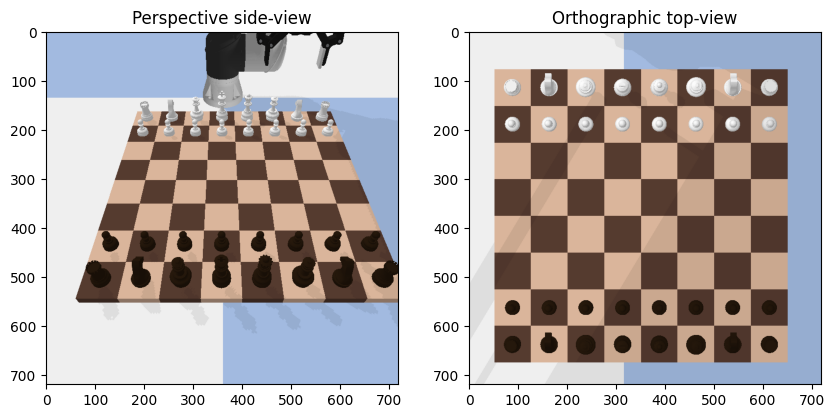

In [11]:
config = {
    'pick': [
        "white King",
        "white Queen",
        "white Rook 1",
        "white Rook 2",
        "white Bishop 1",
        "white Bishop 2",
        "white Knight 1",
        "white Knight 2",
        "white Pawn 1",
        "white Pawn 2",
        "white Pawn 3",
        "white Pawn 4",
        "white Pawn 5",
        "white Pawn 6",
        "white Pawn 7",
        "white Pawn 8",
        "black King",
        "black Queen",
        "black Rook 1",
        "black Rook 2",
        "black Bishop 1",
        "black Bishop 2",
        "black Knight 1",
        "black Knight 2",
        "black Pawn 1",
        "black Pawn 2",
        "black Pawn 3",
        "black Pawn 4",
        "black Pawn 5",
        "black Pawn 6",
        "black Pawn 7",
        "black Pawn 8"
    ]
}





np.random.seed(40)
env = PickPlaceEnv()
obs = env.reset(config)
plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
img = env.get_camera_image()
plt.title('Perspective side-view')
plt.imshow(img)
plt.subplot(1, 2, 2)
img = env.get_camera_image_top()
img = np.flipud(img.transpose(1, 0, 2))
plt.title('Orthographic top-view')
plt.imshow(img)
plt.show()



## Command with Text

In [12]:
class ScriptedPolicy():

  def __init__(self, env):
    self.env = env

  def step(self, text, obs):
    print(f'Input: {text}')

    # Parse pick and place targets.
    pick_text, place_text = text.split('and')
    pick_target, place_target = None, None
    for name in PICK_TARGETS.keys():
      if name in pick_text:
        pick_target = name
        break
    for name in PLACE_TARGETS.keys():
      if name in place_text:
        place_target = name
        break

    # Admissable targets only.
    assert pick_target is not None
    assert place_target is not None

    pick_id = self.env.obj_name_to_id[pick_target]
    pick_pose = pybullet.getBasePositionAndOrientation(pick_id)
    pick_position = np.float32(pick_pose[0])

    if place_target in self.env.obj_name_to_id:
      place_id = self.env.obj_name_to_id[place_target]
      place_pose = pybullet.getBasePositionAndOrientation(place_id)
      place_position = np.float32(place_pose[0])
    else:
      place_position = np.float32(PLACE_TARGETS[place_target])

    # Add some noise to pick and place positions.
    # pick_position[:2] += np.random.normal(scale=0.01)
    # place_position[:2] += np.random.normal(scale=0.01)

    act = {'pick': pick_position, 'place': place_position}
    return act


In [13]:
prompt = 'Pick the white King and place it on the e4 .'
policy = ScriptedPolicy(env)
act = policy.step(prompt, obs)
obs, _, _, _ = env.step(act)


# Show video of environment rollout.
debug_clip = ImageSequenceClip(env.cache_video, fps=25)
display(debug_clip.ipython_display(autoplay=1, loop=1, center=False))
debug_clip.write_videofile("debug_video.mp4", codec="libx264")
env.cache_video = []

Input: Pick the white King and place it on the e4 .
Moviepy - Building video __temp__.mp4.
Moviepy - Writing video __temp__.mp4



Moviepy - Done !
Moviepy - video ready __temp__.mp4


Moviepy - Building video debug_video.mp4.
Moviepy - Writing video debug_video.mp4



Moviepy - Done !
Moviepy - video ready debug_video.mp4


## LLM

In [14]:
import openai
import optax
import pickle
import chess

In [15]:
overwrite_cache = True
if overwrite_cache:
  LLM_CACHE = {}

In [ ]:
with open('llm_cache.pickle', 'wb') as handle:
    pickle.dump(LLM_CACHE, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [16]:
from google.colab import userdata
openai_api_key = userdata.get('OpenAI_API')
ENGINE =   "gpt-4o-mini"
os.environ["OPENAI_API_KEY"] = openai_api_key

In [47]:
# --- Chess Piece and Board Definitions ---
# List of available pieces
AVAILABLE_PIECES = [
    "white King", "white Queen", "white Rook 1", "white Rook 2",
    "white Knight 1", "white Knight 2", "white Bishop 1", "white Bishop 2",
    "white Pawn 1", "white Pawn 2", "white Pawn 3", "white Pawn 4",
    "white Pawn 5", "white Pawn 6", "white Pawn 7", "white Pawn 8",
    "black King", "black Queen", "black Rook 1", "black Rook 2",
    "black Knight 1", "black Knight 2", "black Bishop 1", "black Bishop 2",
    "black Pawn 1", "black Pawn 2", "black Pawn 3", "black Pawn 4",
    "black Pawn 5", "black Pawn 6", "black Pawn 7", "black Pawn 8"
]


# List of available squares
AVAILABLE_SQUARES = []
for row in range(8):
    for col in range(8):
        square_name = chr(ord('a') + col) + str(row + 1)
        AVAILABLE_SQUARES.append(square_name)

# Initial positions
piece_positions = PICK_TARGETS.copy()

# Mapping between our piece representation and python-chess pieces
PIECE_TYPE_MAP = {
    "King": chess.KING,
    "Queen": chess.QUEEN,
    "Rook": chess.ROOK,
    "Bishop": chess.BISHOP,
    "Knight": chess.KNIGHT,
    "Pawn": chess.PAWN
}

# Mapping between our colors and python-chess colors
COLOR_MAP = {
    "white": chess.WHITE,
    "black": chess.BLACK
}

COMMAND_RE = re.compile(
    r"^\s*Pick the\s+(.+?)\s+and place it on the\s+([a-h][1-8])\.?\s*$",
    re.IGNORECASE
)

VALID_PIECES = set(AVAILABLE_PIECES)
VALID_SQUARES = set(AVAILABLE_SQUARES)

In [18]:
# --- Python-Chess Integration Functions ---
def initialize_chess_board():
    """Create a new chess.Board object and set up the pieces according to piece_positions."""
    board = chess.Board(fen=chess.STARTING_FEN)  # Start with standard board
    # We don't need to customize the board since our piece_positions already match standard setup
    return board

board = initialize_chess_board()
print(board)

r n b q k b n r
p p p p p p p p
. . . . . . . .
. . . . . . . .
. . . . . . . .
. . . . . . . .
P P P P P P P P
R N B Q K B N R


In [19]:
def display_board_with_annotations(chess_board, player=None, last_move=None):
    """Display the chess board with annotations showing legal moves for selected pieces."""
    # Create the board visualization
    board_str = "\n  +------------------------+\n"

    # Map for piece symbols
    symbols = {
        (chess.KING, chess.WHITE): "♔", (chess.QUEEN, chess.WHITE): "♕",
        (chess.ROOK, chess.WHITE): "♖", (chess.BISHOP, chess.WHITE): "♗",
        (chess.KNIGHT, chess.WHITE): "♘", (chess.PAWN, chess.WHITE): "♙",
        (chess.KING, chess.BLACK): "♚", (chess.QUEEN, chess.BLACK): "♛",
        (chess.ROOK, chess.BLACK): "♜", (chess.BISHOP, chess.BLACK): "♝",
        (chess.KNIGHT, chess.BLACK): "♞", (chess.PAWN, chess.BLACK): "♟"
    }

    # Create a set of highlighted squares if there's a last move
    highlighted = set()
    if last_move:
        from_sq = chess.parse_square(last_move[0])
        to_sq = chess.parse_square(last_move[1])
        highlighted.add(from_sq)
        highlighted.add(to_sq)

    # Create a set of legal target squares if a player is provided
    legal_targets = {}
    if player:
        color = COLOR_MAP[player]
        for move in chess_board.legal_moves:
            from_sq = move.from_square
            if from_sq not in legal_targets:
                legal_targets[from_sq] = []
            legal_targets[from_sq].append(move.to_square)

    # Display the board
    for rank in range(7, -1, -1):
        board_str += f"{rank+1} | "
        for file in range(8):
            square = chess.square(file, rank)
            piece = chess_board.piece_at(square)

            # Determine background (for highlighting last move)
            bg = "\033[46m" if square in highlighted else "" # Cyan background for highlights

            # Determine what to display
            if piece:
                symbol = symbols.get((piece.piece_type, piece.color), "?")
                board_str += f"{bg}{symbol}\033[0m "
            else:
                board_str += f"{bg}·\033[0m "

        board_str += "|\n"

    board_str += "  +------------------------+\n"
    board_str += "    a b c d e f g h\n"

    # Add legal moves information if available
    if player and legal_targets:
        board_str += f"\nLegal moves for {player}:\n"
        piece_to_square = {v: k for k, v in piece_positions.items() if v}  # Reverse mapping

        for from_sq, to_squares in legal_targets.items():
            from_sq_name = chess.square_name(from_sq)
            if from_sq_name in piece_to_square:
                piece_name = piece_to_square[from_sq_name]
                targets = [chess.square_name(sq) for sq in to_squares]
                if targets:  # Only show pieces that have legal moves
                    board_str += f"- {piece_name} ({from_sq_name}) → {', '.join(targets)}\n"

    # Print evaluation if available
    if hasattr(chess_board, 'score'):
        board_str += f"\nEvaluation: {chess_board.score}\n"

    print(board_str)



In [20]:
def convert_to_uci_move(piece, from_square, to_square):
    """Convert our move representation to UCI format for python-chess."""
    # Convert square names to python-chess format (e.g., "a1" -> chess.A1)
    from_uci = from_square.lower()
    to_uci = to_square.lower()

    # Create UCI move string
    uci_move = from_uci + to_uci

    # Handle promotion for pawns
    piece_type = piece.split()[1]
    if piece_type == "Pawn":
        if (to_square[1] == '8' and piece.startswith("white")) or (to_square[1] == '1' and piece.startswith("black")):
            # Default promotion to queen
            uci_move += 'q'

    return uci_move

In [21]:
def get_legal_moves_for_piece(board, piece, from_square):
    """Get all legal moves for a specific piece at a specific square."""
    from_idx = chess.parse_square(from_square)
    legal_moves = []

    for move in board.legal_moves:
        if move.from_square == from_idx:
            legal_moves.append(chess.square_name(move.to_square))

    return legal_moves


In [22]:
def is_move_legal(board, piece, from_square, to_square):
    """Check if the move is legal according to chess rules."""
    try:
        uci_move = convert_to_uci_move(piece, from_square, to_square)
        move = chess.Move.from_uci(uci_move)
        return move in board.legal_moves
    except ValueError:
        return False


In [23]:
def get_all_legal_moves(board, player_color):
    """Get all legal moves for the current player in our format."""
    color = COLOR_MAP[player_color]
    moves = []

    # Create a mapping from board positions to our pieces
    position_to_piece = {v: k for k, v in piece_positions.items() if k.startswith(player_color)}

    for move in board.legal_moves:
        from_square = chess.square_name(move.from_square)
        to_square = chess.square_name(move.to_square)

        if from_square in position_to_piece:
            piece = position_to_piece[from_square]
            moves.append((piece, to_square))

    return moves


In [24]:
def suggest_moves(chess_board, player):
    """Return a list of suggested legal moves for the player."""
    legal_moves = get_all_legal_moves(chess_board, player)

    if not legal_moves:
        return ["No legal moves available."]

    # Return formatted suggestions
    suggestions = []
    for piece, square in legal_moves[:10]:  # Limit to 10 suggestions to avoid overwhelming
        suggestions.append(f"Pick the {piece} and place it on the {square}")

    return suggestions


In [33]:
def annotate_legal_moves(chess_board, legal_moves):
    annotated = []
    for piece, square in legal_moves:
        move = chess.Move.from_uci(chess_board.parse_san(f"{piece_positions[piece]}{square}").uci())
        tags = []

        # Basic heuristics
        if chess_board.is_capture(move):
            tags.append("capture")
        if square[0] in "de" and square[1] in "34":
            tags.append("center control")
        if piece.split()[1] in ["Knight", "Bishop"]:
            tags.append("development")

        annotated.append((piece, square, tags))
    return annotated

In [60]:
# --- Configuration ---
# Check if API key exists
api_key = os.getenv("OPENAI_API_KEY")
USE_MOCK_API = not api_key  # Use mock API if no key is available

if USE_MOCK_API:
    print("No OpenAI API key found. Using mock LLM for demonstration.")
else:
    openai.api_key = api_key

LLM_MODEL = "gpt-4o"  # Only used with real API



# --- Helper Functions ---
def generate_mock_chess_move(current_player, chess_board):
    """Generate a reasonable chess move when using mock API."""
    # Use python-chess to get legal moves
    legal_moves = get_all_legal_moves(chess_board, current_player)

    if not legal_moves:
        return "Error: No legal moves available"

    # Try to make smarter move selection
    # First, check for captures
    capturing_moves = []
    for piece, to_square in legal_moves:
        # Check if there's an opponent piece at the target square
        opponent_color = "black" if current_player == "white" else "white"
        for opp_piece, opp_pos in piece_positions.items():
            if opp_piece.startswith(opponent_color) and opp_pos == to_square:
                # This is a capturing move
                capturing_moves.append((piece, to_square))
                break

    if capturing_moves:
        # Prioritize captures - choose randomly from available captures
        piece, square = random.choice(capturing_moves)
    else:
        # No captures available, select a random legal move
        piece, square = random.choice(legal_moves)

    # Return properly formatted command
    return f"Pick the {piece} and place it on the {square}"



def parse_pick_place_command(command_str):
    """Parses 'Pick the X and place it on the Y.'"""
    if not isinstance(command_str, str):
        return None

    m = COMMAND_RE.match(command_str.strip())
    if not m:
        return None

    piece, square = m.group(1).strip(), m.group(2).strip()
    if piece not in VALID_PIECES or square not in VALID_SQUARES:
        return None

    return {"piece": piece, "square": square}

def format_board_description():
    """Creates a textual representation of the board."""
    board_desc = "Current board state (piece locations):\n"
    board_desc += "\n".join([f"- {name}: {loc}" for name, loc in sorted(piece_positions.items())])
    return board_desc



def get_chess_move(player, chess_board, previous_failures=None):
    """Get a chess move for the specified player with improved handling for illegal moves."""
    if USE_MOCK_API:
        # Generate a mock move using python-chess (always legal)
        move = generate_mock_chess_move(player, chess_board)
        print(f"Generated mock move: {move}")
        return move
    else:
        # Get ALL legal moves for better guidance
        all_legal_moves = get_all_legal_moves(chess_board, player)

        if not all_legal_moves:
            print("No legal moves available - game should be over.")
            return "No legal moves available"

        # Format legal moves by piece for better organization
        legal_moves_by_piece = {}
        for piece, square in all_legal_moves:
            if piece not in legal_moves_by_piece:
                legal_moves_by_piece[piece] = []
            legal_moves_by_piece[piece].append(square)

        # Format the legal moves in a clear, structured way
        legal_moves_formatted = []
        for piece, squares in legal_moves_by_piece.items():
            moves_str = f"- {piece} can move to: {', '.join(sorted(squares))}"
            legal_moves_formatted.append(moves_str)

        # Join the formatted moves with line breaks
        legal_moves_display = "\n".join(legal_moves_formatted)
        print(f"Legal moves for {player}:\n{legal_moves_display}")

        # Include feedback from previous illegal moves if available
        feedback_str = ""
        if previous_failures:
            feedback_str = "IMPORTANT - Previous illegal move attempts:\n"
            for move, reason in previous_failures:
                feedback_str += f"- '{move}' was illegal because: {reason}\n"

        # Enhanced system prompt with more explicit instructions
        call_law_prompt = f"""You are an expert chess engine controlling a pick-and-place robot in a chess game.
Your task is to determine a strong chess move for {player} and output the precise robot command.

OUTPUT FORMAT REQUIREMENTS:
Return ONLY this format with no additional text: "Pick the [piece name] and place it on the [square name]"
example: pick the black Bishop 1 and place it on the e8.

STRICT REQUIREMENTS:
1. You MUST select from THESE EXACT piece names only:
   {', '.join(sorted(p for p in AVAILABLE_PIECES if p.startswith(player)))}

2. For pawns, knights, bishops and rooks, ALWAYS include the specific number (e.g., "white Pawn 3", not just "white Pawn")

Do not explain your reasoning or add commentary - output ONLY the required format.

The initial positions at the starting of the game were: {PICK_TARGETS}
"""

        # Create a visual representation of the board
        board_visual = []
        for i in range(8, 0, -1):  # Ranks 8 to 1
            rank = []
            for file in 'abcdefgh':
                square = file + str(i)
                piece_at_square = None
                for piece, pos in piece_positions.items():
                    if pos == square:
                        piece_at_square = piece
                        break
                rank.append(piece_at_square if piece_at_square else "empty")
            board_visual.append(rank)

        # Format the board visual as a string
        board_visual_str = "Visual board representation:\n"
        for i, rank in enumerate(board_visual):
            rank_str = f"{8-i} | "
            for piece in rank:
                if piece == "empty":
                    rank_str += "·····  "
                else:
                    # Abbreviate piece name to fit better
                    color = piece.split()[0][0]  # 'r' or 'b'
                    piece_type = piece.split()[1][0]  # First letter of piece type
                    num = piece.split()[2] if len(piece.split()) > 2 else ""
                    rank_str += f"{color}{piece_type}{num}".ljust(6)
            board_visual_str += rank_str + "\n"
        board_visual_str += "   a     b     c     d     e     f     g     h"

        board_state_str = format_board_description()
        query_prompt = f"""Current board state:
{chess_board.fen()}

Move History:
{chess_board.move_stack}

{feedback_str}
It is {player}'s turn to move.
Available legal moves for {player}:
{legal_moves_display}
It's important for White to play London System. You should prioritize: 1.d4, 2.Nf3, 3.Bf4, 4.e3, 5.c3, 6.Nbd2.
Black should respond with Indian king defence. Continue according to the theory.
It's Important to provide the responce with the provided format.
"""

        try:
            # Use higher temperature for first attempt, lower for retries
            temp = 0.9 if not previous_failures else 0.7

            response = openai.chat.completions.create(
                model=LLM_MODEL,
                messages=[
                    {"role": "system", "content": call_law_prompt},
                    {"role": "user", "content": query_prompt}
                ],
                temperature=temp,
                max_tokens=60
            )
            content = response.choices[0].message.content.strip()
            print(f"API Response: {content}")
            return content
        except Exception as e:
            print(f"API Error: {e}")
            # Fall back to mock response - which is guaranteed legal
            print("Falling back to mock response...")
            return generate_mock_chess_move(player, chess_board)


In [61]:

def execute_move(chess_board, move_command):
    """Execute a chess move based on the command."""
    parsed_move = parse_pick_place_command(move_command)
    capturing = False
    piece_to_capture = None

    if not parsed_move:
        print(f"Invalid format: {move_command}")
        return False, "Invalid command format",chess_board,capturing,piece_to_capture

    player = "white" if chess_board.turn == chess.WHITE else "black"
    if not parsed_move["piece"].startswith(player):
        print(f"Wrong player's piece: {move_command}")
        return False, f"That's not a {player} piece",chess_board,capturing,piece_to_capture

    piece = parsed_move["piece"]
    to_square = parsed_move["square"]
    from_square = piece_positions.get(piece, "unknown")

    if from_square == "unknown":
        print(f"Piece not found on board: {piece}")
        return False, f"Piece {piece} not found on board",chess_board,capturing,piece_to_capture

    # Check if the move is legal using python-chess
    if is_move_legal(chess_board, piece, from_square, to_square):
        # Execute the move in our representation
        piece_positions[piece] = to_square

        # Execute the move in python-chess
        uci_move = convert_to_uci_move(piece, from_square, to_square)
        chess_board.push_uci(uci_move)

        print("\n====== Move Executed ======")
        print(f"Move: {move_command}")
        print(f"Moved {piece} from {from_square} to {to_square}")
        print(f"UCI move: {uci_move}")

        # Check if this move captured a piece
        for opp_piece, opp_pos in list(piece_positions.items()):
            if opp_piece.startswith("white" if player == "black" else "black") and opp_pos == to_square:
                if opp_piece != piece:  # Make sure we're not checking the piece that just moved
                    capturing = True
                    piece_to_capture = opp_piece
                    print(f"Captured {opp_piece}!")
                    piece_positions[opp_piece] = ""  # Mark as captured

        # Check for special game states
        if chess_board.is_check():
            print(f"CHECK! {player} has put {'black' if player == 'white' else 'white'} in check!")
        if chess_board.is_checkmate():
            print(f"CHECKMATE! {player} wins!")
            return True, "checkmate",chess_board,capturing,piece_to_capture
        if chess_board.is_stalemate():
            print("STALEMATE! Game ends in a draw.")
            return True, "stalemate",chess_board,capturing,piece_to_capture
        if chess_board.is_insufficient_material():
            print("DRAW! Insufficient material to continue.")
            return True, "insufficient material",chess_board,capturing,piece_to_capture



        return True, "success",chess_board,capturing,piece_to_capture
    else:
        # Get more specific information about why the move is illegal
        reason = "Not a legal chess move"

        # Check for more specific reasons
        if piece.split()[1] == "Pawn":
            # Handle pawn-specific issues
            if abs(int(to_square[1]) - int(from_square[1])) > 2:
                reason = "Pawns can only move 1-2 squares"
            elif to_square[0] != from_square[0] and not any(p for p, pos in piece_positions.items()
                                                       if pos == to_square and p.startswith("white" if player == "black" else "black")):
                reason = "Pawns can only move diagonally when capturing"
            elif to_square[0] == from_square[0] and any(p for p, pos in piece_positions.items() if pos == to_square):
                reason = "Pawns cannot capture forward"
        elif piece.split()[1] == "Knight":
            reason = "Knights must move in an L-shape (2 squares in one direction, then 1 square perpendicular)"
        elif piece.split()[1] in ["Rook", "Bishop", "Queen"]:
            reason = f"{piece.split()[1]}s cannot jump over pieces"

        print(f"Illegal move attempted: {move_command}")
        print(f"Reason: {reason}")
        return False, reason,chess_board,capturing,piece_to_capture

def robot_move(chess_board):
    """Generate and execute a single chess move for the robot.
    Returns the prompt that should be sent to the robot.
    """
    player = "white" if chess_board.turn == chess.WHITE else "black"
    print(f"\nGenerating move for {player}...")

    move_command = get_chess_move(player, chess_board)

    # For the robot interface, we return the command
    return move_command


def do_it(move_command,obs):
  act = policy.step(move_command, obs)
  obs, _, _, _ = env.step(act)

  return obs


In [62]:
env = PickPlaceEnv()
obs = env.reset(config)
chess_board = initialize_chess_board()
piece_positions = PICK_TARGETS.copy()
policy = ScriptedPolicy(env)

# Generate a move command
image_sequence=[]
captured_white_count=0
captured_black_count=0
capturing=False
piece_to_capture=None
capture_count = None
for i in range(20):
  print(f'==================== iteration {i} ========================')
  success = False
  while not success:
      move_command = robot_move(chess_board)
      success, status,chess_board,capturing,piece_to_capture = execute_move(chess_board, move_command)

  print(f'now is the turn for {"white" if not chess_board.turn == chess.WHITE else "black"}')


  if success:
      if capturing:
          print("Capturing")
          color = "white" if not chess_board.turn == chess.WHITE else "black"
          if color=="white":
              captured_white_count += 1
              capture_count = captured_white_count
          else:
              captured_black_count += 1
              capture_count = captured_black_count

          print(f'Pick the {color} {piece_to_capture} and place it on the captured {color} {capture_count}')
          capture_command = f'Pick the {color} {piece_to_capture} and place it on the captured {color} 1'
          obs = do_it(capture_command,obs)
      print("Move executed successfully!")
      obs = do_it(move_command,obs)



  else:
      print(f"Move failed: {status}")
image_sq=env.cache_video
debug_clip = ImageSequenceClip(image_sq, fps=25)
display(debug_clip.ipython_display(autoplay=1, loop=1, center=False))
debug_clip.write_videofile("debug_video.mp4", codec="libx264")
env.cache_video = []

Output hidden; open in https://colab.research.google.com to view.